# 一、准备工作

In [68]:
import sys
print(sys.version)
print(sys.version_info)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)


## 1.1安装工具包

In [1]:
# 安装lgb、xgb、ctb决策树、matplotlib
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple lightgbm
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple xgboost
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple catboost
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## 1.2导入库

In [2]:
# pandas和numpy用于数据预处理；sklearn用于模型训练；xgb、lgb、ctb为决策树，用在模型主体；matplotlib用于绘图
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 

## 1.3导入数据

In [3]:
# 导入数据
train_abbr=pd.read_csv("./Dataset/happiness_train_abbr.csv",encoding='ISO-8859-1')
train=pd.read_csv("./Dataset/happiness_train_complete.csv",encoding='ISO-8859-1')
test_abbr=pd.read_csv("./Dataset/happiness_test_abbr.csv",encoding='ISO-8859-1')
test=pd.read_csv("./Dataset/happiness_test_complete.csv",encoding='ISO-8859-1')
test_sub=pd.read_csv("./Dataset/happiness_submit.csv",encoding='ISO-8859-1')

# 二、数据预处理

## 2.1观察数据

In [4]:
#观察数据大小
print(test.shape)
print(test_sub.shape)
print(train.shape)
#简单查看数据
print(train.head())
#查看数据是否缺失
print(train.info(verbose=True,null_counts=True))
print(train_abbr.columns)#查看train_abbr所有特征列
print(train.columns)#查看train所有特征列

(2968, 139)
(2968, 2)
(8000, 140)
   id  happiness  survey_type  province  city  county      survey_time  \
0   1          4            1        12    32      59   2015/8/4 14:18   
1   2          4            2        18    52      85  2015/7/21 15:04   
2   3          4            2        29    83     126  2015/7/21 13:24   
3   4          5            2        10    28      51  2015/7/25 17:33   
4   5          4            1         7    18      36   2015/8/10 9:50   

   gender  birth  nationality  ...  neighbor_familiarity  public_service_1  \
0       1   1959            1  ...                     4                50   
1       1   1992            1  ...                     3                90   
2       2   1967            1  ...                     4                90   
3       2   1943            1  ...                     3               100   
4       2   1994            1  ...                     2                50   

   public_service_2 public_service_3  public_service

## 2.2处理原始数据

### 2.2.1处理训练集数据

In [5]:
# 对训练集（train）处理
# 已有edu_status属性，这一列大部分是空，去掉
train = train.drop(['edu_other'],axis = 1)
# 家中有多少个18岁以下的孩子，没填视为没有，填0
train['minor_child'] = train['minor_child'].fillna(value=0)
list1 = []
# 对property独热编码，01的组合看作二进制数，转整数
for a,b,c,d,e,f,g,h,i,j in zip(train['property_0'],train['property_1'],train['property_2'],train['property_3'],train['property_4'],train['property_5'],train['property_6'],train['property_7'],train['property_8'],train['property_other']):
    item = 0
    item = 1*a+2*b+4*c+8*d+16*e+32*f+64*g+128*h+256*i
    if('共' in str(j)):
        print(a,b,c,d,e,f,g,h,i,j)
        item = 1+2+4+8+16+32+64+128
    list1.append(item)
# 添加此新属性为property
train.insert(20,'property',list1)
# 删除原先的property
train = train.drop(['property_0','property_1','property_2','property_3','property_5','property_4','property_6','property_7','property_8','property_other'],1)
list1 = []
train['invest_other'] = train['invest_other'].fillna(value=-1)
# 对invest独热编码，01的组合看作二进制数，转整数
for a,b,c,d,e,f,g,h,i,j in zip(train['invest_0'],train['invest_1'],train['invest_2'],train['invest_3'],train['invest_4'],train['invest_5'],train['invest_6'],train['invest_7'],train['invest_8'],train['invest_other']):
    item = 0
    item = 1*a+2*b+4*c+8*d+16*e+32*f+64*g+128*h+256*i
    if(not('-1' in str(j))):
        item = 1+2+4+8+16+32+64+128
    list1.append(item)
# 添加此新属性为invest
train.insert(71,'invest',list1)
# 删除原先的invest
train = train.drop(['invest_0','invest_1','invest_2','invest_3','invest_5','invest_4','invest_6','invest_7','invest_8','invest_other'],1)
list1 = train.keys()
# 根据index的说明，空数据视为不适用，填成-1
for item in list1:
    train[item] = train[item].fillna(value=-1)

### 2.2.2处理测试集数据

In [6]:
# 对测试集（test）处理
# 已有edu_status属性，这一列大部分是空，去掉
test = test.drop(['edu_other'],axis = 1)
# 家中有多少个18岁以下的孩子，没填视为没有，填0
test['minor_child'] = test['minor_child'].fillna(value=0)
list1 = []
# 对property独热编码，01的组合看作二进制数，转整数
for a,b,c,d,e,f,g,h,i,j in zip(test['property_0'],test['property_1'],test['property_2'],test['property_3'],test['property_4'],test['property_5'],test['property_6'],test['property_7'],test['property_8'],test['property_other']):
    item = 0
    item = 1*a+2*b+4*c+8*d+16*e+32*f+64*g+128*h+256*i
    if('共' in str(j)):
        print(a,b,c,d,e,f,g,h,i,j)
        item = 1+2+4+8+16+32+64+128
    list1.append(item)
# 添加此新属性为property
test.insert(20,'property',list1)
# 删除原先的property
test = test.drop(['property_0','property_1','property_2','property_3','property_5','property_4','property_6','property_7','property_8','property_other'],1)
list1 = []
test['invest_other'] = test['invest_other'].fillna(value=-1)
# 对invest独热编码，01的组合看作二进制数，转整数
for a,b,c,d,e,f,g,h,i,j in zip(test['invest_0'],test['invest_1'],test['invest_2'],test['invest_3'],test['invest_4'],test['invest_5'],test['invest_6'],test['invest_7'],test['invest_8'],test['invest_other']):
    item = 0
    item = 1*a+2*b+4*c+8*d+16*e+32*f+64*g+128*h+256*i
    if(not('-1' in str(j))):
        item = 1+2+4+8+16+32+64+128
    list1.append(item)
# 添加此新属性为invest
test.insert(71,'invest',list1)
# 删除原先的invest
test = test.drop(['invest_0','invest_1','invest_2','invest_3','invest_5','invest_4','invest_6','invest_7','invest_8','invest_other'],1)
list1 = test.keys()
# 根据index的说明，空数据视为不适用，填成-1
for item in list1:
    test[item] = test[item].fillna(value=-1)

## 2.3处理happiness属性

In [7]:
#查看label分布
y_train_=train["happiness"]
# y_train_.value_counts()
print(y_train_.value_counts())
#将含有-8的行直接去掉
print(train.index[0])
for lin,q in zip(range(0,len(y_train_)),y_train_):
    if(q == -8):
        train = train.drop(index=[lin])
# y_train_=y_train_.map(lambda x:3 if x==-8 else x)
#让label从0开始
y_train_=y_train_.map(lambda x:x-1)
#train和test连在一起
data = pd.concat([train,test],axis=0,ignore_index=True)
#全部数据大小
print(data.shape)

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64
0
(10956, 121)


## 2.4处理时间特征

In [8]:
#处理时间特征
data['survey_time'] = pd.to_datetime(data['survey_time'],format='%Y-%m-%d %H:%M:%S')
data["weekday"]=data["survey_time"].dt.weekday
data["year"]=data["survey_time"].dt.year
data["quarter"]=data["survey_time"].dt.quarter
data["hour"]=data["survey_time"].dt.hour
data["month"]=data["survey_time"].dt.month

In [9]:
# 把一天的时间分段
def hour_cut(x):
    if 0 <= x < 6:
        return 0
    elif 6 <= x < 8:
        return 1
    elif 8 <= x < 12:
        return 2
    elif 12 <= x < 14:
        return 3
    elif 14 <= x < 18:
        return 4
    elif 18 <= x < 21:
        return 5
    elif 21 <= x < 24:
        return 6

data["hour_cut"] = data["hour"].map(hour_cut)

# 做问卷时候的年龄
data["survey_age"]=data["year"]-data["birth"]

## 2.5处理其他特征

In [10]:
# 让label从0开始
data["happiness"]=data["happiness"].map(lambda x:x-1)

data=data.drop(["happiness"], axis=1) # 需要预测的结果，去掉一列
data=data.drop(["survey_time"], axis=1) # 已处理成survey_age属性，删去

# 是否入党
data["join_party"]=data["join_party"].map(lambda x:0 if x == -1  else 1)

## 2.6查看数据并保存到csv文件

In [11]:
data.head(40) # 查看处理完的数据

,id,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,...,public_service_7,public_service_8,public_service_9,weekday,year,quarter,hour,month,hour_cut,survey_age
0,1,1,12,32,59,1,1959,1,1,1,...,50,50,50,1,2015,3,14,8,4,56
1,2,2,18,52,85,1,1992,1,1,1,...,90,60,60,1,2015,3,15,7,4,23
2,3,2,29,83,126,2,1967,1,0,3,...,90,90,75,1,2015,3,13,7,3,48
3,4,2,10,28,51,2,1943,1,1,1,...,90,80,80,5,2015,3,17,7,4,72
4,5,1,7,18,36,2,1994,1,1,1,...,50,50,50,0,2015,3,9,8,2,21
5,6,2,18,52,86,1,1946,1,1,1,...,80,90,90,5,2015,3,12,7,3,69
6,7,1,10,27,49,1,1963,1,1,1,...,60,80,80,6,2015,3,14,7,4,52
7,8,1,11,31,54,1,1959,1,0,8,...,80,70,70,6,2015,3,13,7,3,56
8,9,2,28,81,122,1,1952,1,1,1,...,86,87,85,5,2015,3,9,8,2,63
9,10,2,24,70,110,1,1985,1,1,1,...,60,60,60,0,2015,3,19,8,5,30


In [12]:
path = "data_1126.csv"
data.to_csv(path,sep=",",index=False,header=True)

# 三、数据可视化分析

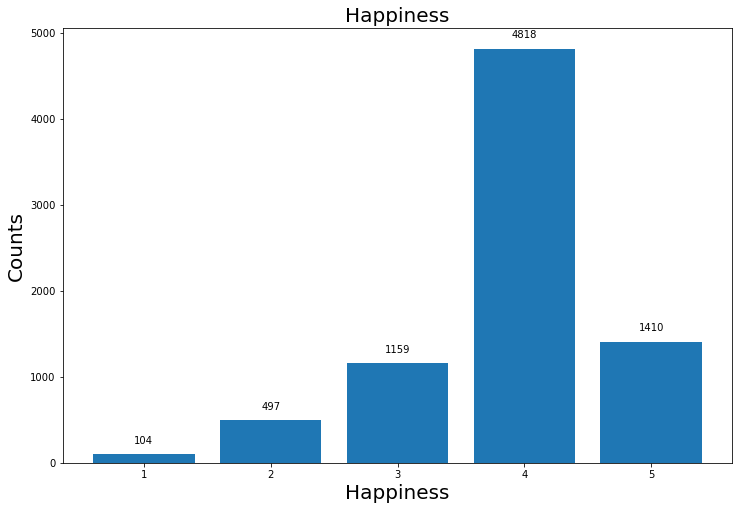

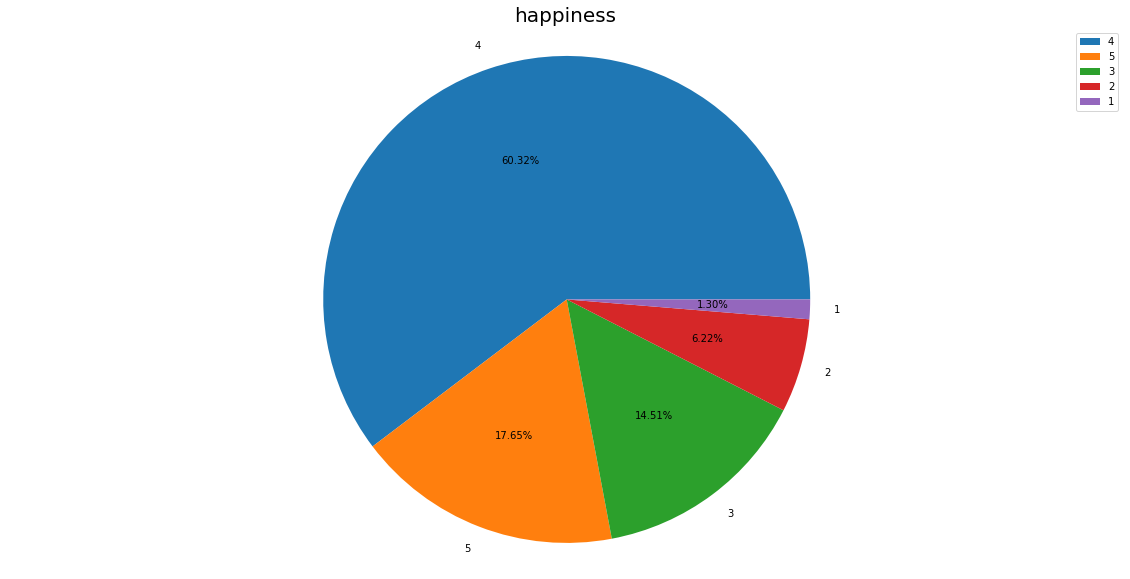

depression
class
health
equity
family_status
health_problem
class_10_after
public_service_6
class_10_before
public_service_7


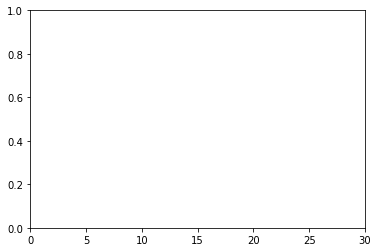

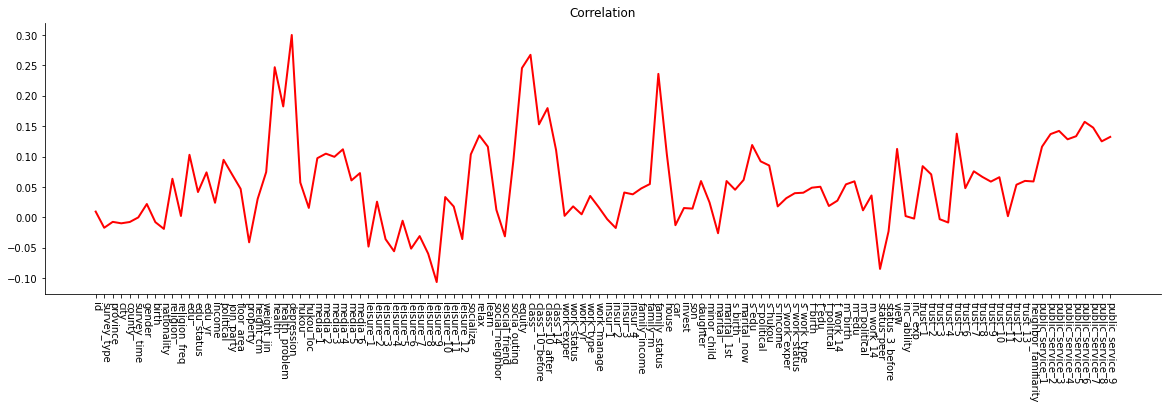

In [65]:
#绘韌happiness条形图
train_type = train.happiness.value_counts()
x = train_type.index
y = train_type.values
plt.figure(figsize=(12,8))
#条形图
plt.bar(x,y)
#设置标题、横轴、纵轴
plt.title('Happiness',fontsize=20)
plt.xlabel('Happiness',fontsize=20)
plt.ylabel('Counts',fontsize=20)
#坐标轴
plt.tick_params(labelsize = 10)
#设置数字标签
for a,b in zip(x,y):
    plt.text(a,b+100,b,ha= 'center', va = 'bottom')
plt.savefig('happiness.png')
plt.show()

#绘制happiness饼图
plt.figure(figsize =(20,10))
train_type = train.happiness.value_counts()
plt.pie(train_type,labels = train_type.index, autopct='%.2f%%', shadow = False)
plt.title('happiness',fontsize=20)
plt.axis('equal')
plt.legend()
plt.show()

#绘制happiness与其他指标相关系数
plt.xlim((0, 30))
plt.figure(figsize =(20,5))
plt.xticks(rotation=270)
data = pd.read_csv('./Dataset/happiness_train_complete_washed.csv',encoding='gbk')
name = data.columns.values.tolist()
name.remove("happiness")
happ = pd.Series(data['happiness'])
corr = []
for i in name:
    q = data[i]
    s1 = pd.Series(q)
    try:
        corr.append(happ.corr(s1))
    except TypeError:
        corr.append(0)
corr_sort = np.argsort(corr) #按降序排列
corrlen = len(corr_sort)
corr_max10 = []
for j in range(corrlen - 10, corrlen):
    corr_max10.append(name[corr_sort[j]])
#输出相关系数前10的属性
for k in range(len(corr_max10)):
    print(corr_max10[len(corr_max10) - k - 1])
ln1= plt.plot(name,corr,color='red',linewidth=2.0,linestyle='-')
plt.title("Correlation") #设置标题及字体
ax = plt.gca()
ax.spines['right'].set_color('none')  # right边框属性设置为none 不显示
ax.spines['top'].set_color('none')    # top边框属性设置为none 不显示
plt.savefig('corr.png')
plt.show()

# 四、模型训练

## 4.1划分数据集

In [42]:
data=data.drop(["id"], axis=1)
X_train_ = data[:train.shape[0]] # 训练集
X_test_  = data[train.shape[0]:] # 测试集
target_column = 'happiness'
feature_columns=list(X_test_.columns) 
feature_columns

['survey_type',
 'province',
 'city',
 'county',
 'gender',
 'birth',
 'nationality',
 'religion',
 'religion_freq',
 'edu',
 'edu_status',
 'edu_yr',
 'income',
 'political',
 'join_party',
 'floor_area',
 'property',
 'height_cm',
 'weight_jin',
 'health',
 'health_problem',
 'depression',
 'hukou',
 'hukou_loc',
 'media_1',
 'media_2',
 'media_3',
 'media_4',
 'media_5',
 'media_6',
 'leisure_1',
 'leisure_2',
 'leisure_3',
 'leisure_4',
 'leisure_5',
 'leisure_6',
 'leisure_7',
 'leisure_8',
 'leisure_9',
 'leisure_10',
 'leisure_11',
 'leisure_12',
 'socialize',
 'relax',
 'learn',
 'social_neighbor',
 'social_friend',
 'socia_outing',
 'equity',
 'class',
 'class_10_before',
 'class_10_after',
 'class_14',
 'work_exper',
 'work_status',
 'work_yr',
 'work_type',
 'work_manage',
 'insur_1',
 'insur_2',
 'insur_3',
 'insur_4',
 'family_income',
 'family_m',
 'family_status',
 'house',
 'car',
 'invest',
 'son',
 'daughter',
 'minor_child',
 'marital',
 'marital_1st',
 's_birth',
 '

## 4.2转numpy数组

In [46]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(7988, 125)
(7988,)
(2968, 125)


## 4.3自定义评价函数

In [48]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

## 4.4xgb

In [49]:
##### xgb

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[22:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:2.49555	valid_data-rmse:2.48746	train-myFeval:6.22776	valid_data-myFeval:6.18745
Multiple eval metrics have been passed: 'valid_data-myFeval' will be used for early stopping.

Will train until valid_data-myFeval hasn't improved in 200 rounds.
[100]	train-rmse:1.61241	valid_data-rmse:1.60934	train-myFeval:2.59988	valid_data-myFeval:2.58999
[200]	train-rmse:1.11344	valid_data-rmse:1.12201	train-myFeval:1.23975	val

[600]	train-rmse:0.61771	valid_data-rmse:0.70637	train-myFeval:0.38156	valid_data-myFeval:0.49896
[700]	train-rmse:0.59804	valid_data-rmse:0.70012	train-myFeval:0.35765	valid_data-myFeval:0.49018
[800]	train-rmse:0.58428	valid_data-rmse:0.69735	train-myFeval:0.34138	valid_data-myFeval:0.48629
[900]	train-rmse:0.57343	valid_data-rmse:0.69608	train-myFeval:0.32883	valid_data-myFeval:0.48453
[1000]	train-rmse:0.56377	valid_data-rmse:0.69523	train-myFeval:0.31784	valid_data-myFeval:0.48334
[1100]	train-rmse:0.55497	valid_data-rmse:0.69485	train-myFeval:0.30799	valid_data-myFeval:0.48281
[1200]	train-rmse:0.54679	valid_data-rmse:0.69456	train-myFeval:0.29898	valid_data-myFeval:0.48241
[1300]	train-rmse:0.53914	valid_data-rmse:0.69441	train-myFeval:0.29067	valid_data-myFeval:0.48221
[1400]	train-rmse:0.53174	valid_data-rmse:0.69421	train-myFeval:0.28275	valid_data-myFeval:0.48192
[1500]	train-rmse:0.52445	valid_data-rmse:0.69377	train-myFeval:0.27504	valid_data-myFeval:0.48132
[1600]	train-r

[2000]	train-rmse:0.48545	valid_data-rmse:0.68502	train-myFeval:0.23566	valid_data-myFeval:0.46925
[2100]	train-rmse:0.47970	valid_data-rmse:0.68497	train-myFeval:0.23011	valid_data-myFeval:0.46918
[2200]	train-rmse:0.47349	valid_data-rmse:0.68498	train-myFeval:0.22419	valid_data-myFeval:0.46920
Stopping. Best iteration:
[2055]	train-rmse:0.48221	valid_data-rmse:0.68485	train-myFeval:0.23252	valid_data-myFeval:0.46903

[22:20:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
CV score: 0.45896208


## 4.5lgb

In [50]:
##### lgb

param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
   # print(trn_idx)
   # print(".............x_train.........")
   # print(X_train[trn_idx])
  #  print(".............y_train.........")
  #  print(y_train[trn_idx])
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))

fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.433679	valid_1's l2: 0.491021
[400]	training's l2: 0.36794	valid_1's l2: 0.464988
[600]	training's l2: 0.328749	valid_1's l2: 0.45844
[800]	training's l2: 0.298564	valid_1's l2: 0.455187
Early stopping, best iteration is:
[831]	training's l2: 0.294161	valid_1's l2: 0.454931
fold n°2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.436024	valid_1's l2: 0.474453
[400]	training's l2: 0.370871	valid_1's l2: 0.449585
[600]	training's l2: 0.330496	valid_1's l2: 0.444188
[800]	training's l2: 0.299656	valid_1's l2: 0.444065
Early stopping, best iteration is:
[805]	training's l2: 0.298993	valid_1's l2: 0.443948
fold n°3
[LightG

## 4.6ctb

In [51]:
from catboost import Pool, CatBoostRegressor
# cat_features=[0,2,3,10,11,13,15,16,17,18,19]
from sklearn.model_selection import train_test_split


#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_, y_train_, test_size=0.3, random_state=2019)
# train_pool = Pool(X_train_s, y_train_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# val_pool = Pool(X_test_s, y_test_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# test_pool = Pool(X_test_ ,cat_features=[0,2,3,10,11,13,15,16,17,18,19]) 


kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits



print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))


fold n°0
0:	learn: 0.8028247	test: 0.8408703	best: 0.8408703 (0)	total: 4.45ms	remaining: 7m 25s
100:	learn: 0.6593075	test: 0.7228722	best: 0.7228722 (100)	total: 418ms	remaining: 6m 53s
200:	learn: 0.6298304	test: 0.7146051	best: 0.7146051 (200)	total: 822ms	remaining: 6m 48s
300:	learn: 0.6023337	test: 0.7120071	best: 0.7119453 (299)	total: 1.2s	remaining: 6m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7113254721
bestIteration = 322

Shrink model to first 323 iterations.
fold n°1
0:	learn: 0.8034998	test: 0.8413932	best: 0.8413932 (0)	total: 4.58ms	remaining: 7m 37s
100:	learn: 0.6607993	test: 0.7121621	best: 0.7121621 (100)	total: 392ms	remaining: 6m 27s
200:	learn: 0.6305290	test: 0.7050237	best: 0.7049283 (197)	total: 791ms	remaining: 6m 32s
300:	learn: 0.6019865	test: 0.7030709	best: 0.7028654 (277)	total: 1.19s	remaining: 6m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7028654067
bestIteration = 277

Shrink model to first 2

## 4.7模型融合

In [52]:
from sklearn import linear_model
# 将lgb和xgb和ctb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb,oof_cb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb,predictions_cb]).transpose()


folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = linear_model.BayesianRidge()
    #clf_3 =linear_model.Ridge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, y_train_)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.45717501


# 五、预测结果

In [53]:
result=list(predictions)
result=list(map(lambda x: x + 1, result))
test_sub["happiness"]=result
test_sub.to_csv("submit_20201122_2.csv", index=False)